## Transformers in Vision 1

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Patch Embeddings
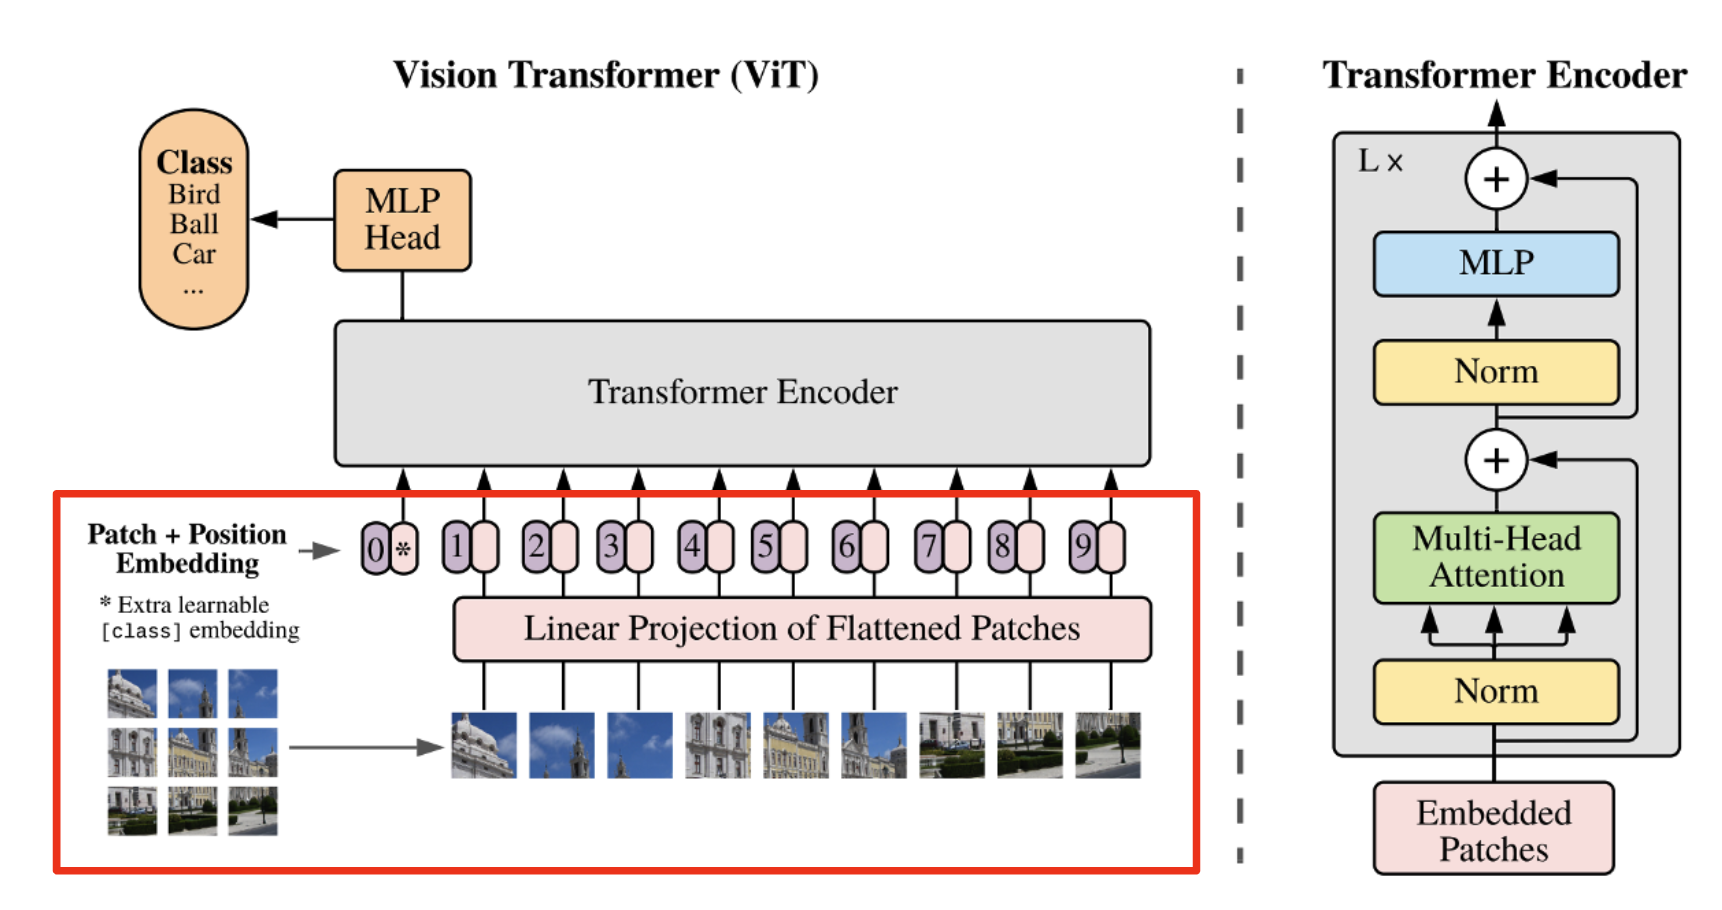


In [ ]:
import torch
import torch.nn as nn

class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.

    Parameters
    ----------
    img_size : int 
        Size of the image (it is a square).

    patch_size : int
        Size of the patch (it is a square).

    in_chans : int 
        Number of input channels. -> grey인 경우 1, RGB인 경우 3

    embed_dim : int
        The emmbedding dimension.

    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.

    proj : nn.Conv2d 
        Convolutional layer that does both the splitting into patches
        and their embedding. -> image를 patch로 나누는데 사용
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2 #image size와 patch size를 받아서 patch 개수 계산

        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        ) # kernel_size와 stride에 전부 patch_size를 넣음 -> overlapping되지 않게 slide 됨 -> kernel이 patch로

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor -> image의 batch
            Shape `(n_samples, in_chans, img_size, img_size)`. #n_samples: batch_size, img_size: height, weight

        Returns
        -------
        torch.Tensor -> n
            Shape `(n_samples, n_patches, embed_dim)`. #n_patches: 이미지를 나누는 patches, embed_dim: embedding dimension
        """
        x = self.proj(
                x
            ) # -> projection수행 후 4-dimensional tensor 얻음
        x = x.flatten(2)  # -> 마지막 두 dimension(degree of patches)를 flatten
        x = x.transpose(1, 2)

        return x

### Multi-Head Attention

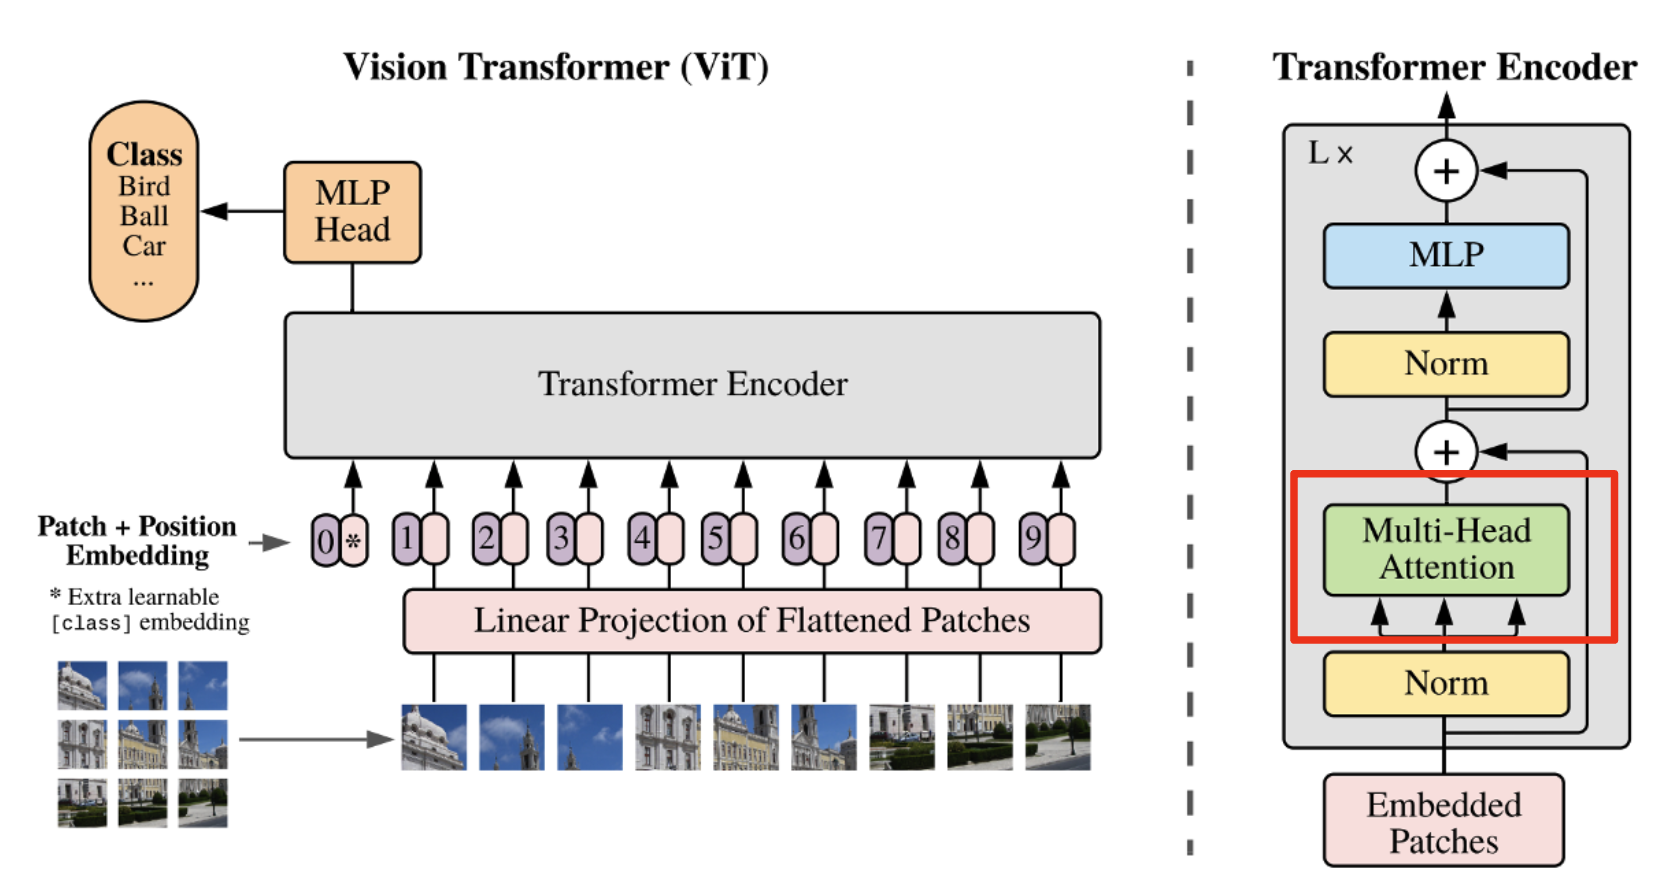

In [ ]:
class Attention(nn.Module):
    """Attention mechanism.

    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.

    n_heads : int
        Number of attention heads.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    attn_p : float
        Dropout probability applied to the query, key and value tensors. -> 본 코드에서는 사용 X

    proj_p : float
        Dropout probability applied to the output tensor. -> 본 코드에서는 사용 X


    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.

    qkv : nn.Linear
        Linear projection for the query, key and value.

    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.

    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads # dimensionality for each of the heads
        self.scale = self.head_dim ** -0.5 #scale: 1/root(dim)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias) #3 separate linear mapping(query, key, value)를 분할하기 위해
        self.attn_drop = nn.Dropout(attn_p) #dropout
        self.proj = nn.Linear(dim, dim) #concat heads
        self.proj_drop = nn.Dropout(proj_p) #dropout

    def forward(self, x):
        """Run forward pass.
        #input과 output의 tensor shape가 동일!

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`. # n_patches + 1인 이유: class token을 attention 이전부터 붙이기 때문
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        ) 
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # dot_product를 위해 transpose
        dp = (
           q @ k_t
        ) * self.scale # dot product 계산
        attn = dp.softmax(dim=-1)  # 마지막 dimension에 softmax 적용
        # attn = self.attn_drop(attn) #dropout

        weighted_avg = attn @ v  # value를 곱해 최종 attention 계산
        weighted_avg = weighted_avg.transpose(
                1, 2
        )
        weighted_avg = weighted_avg.flatten(2)

        x = self.proj(weighted_avg)  # linear projection
        # x = self.proj_drop(x)  # dropout

        return x

### MLP
* hidden dimension으로 한번 갔다가 돌아오는 구조

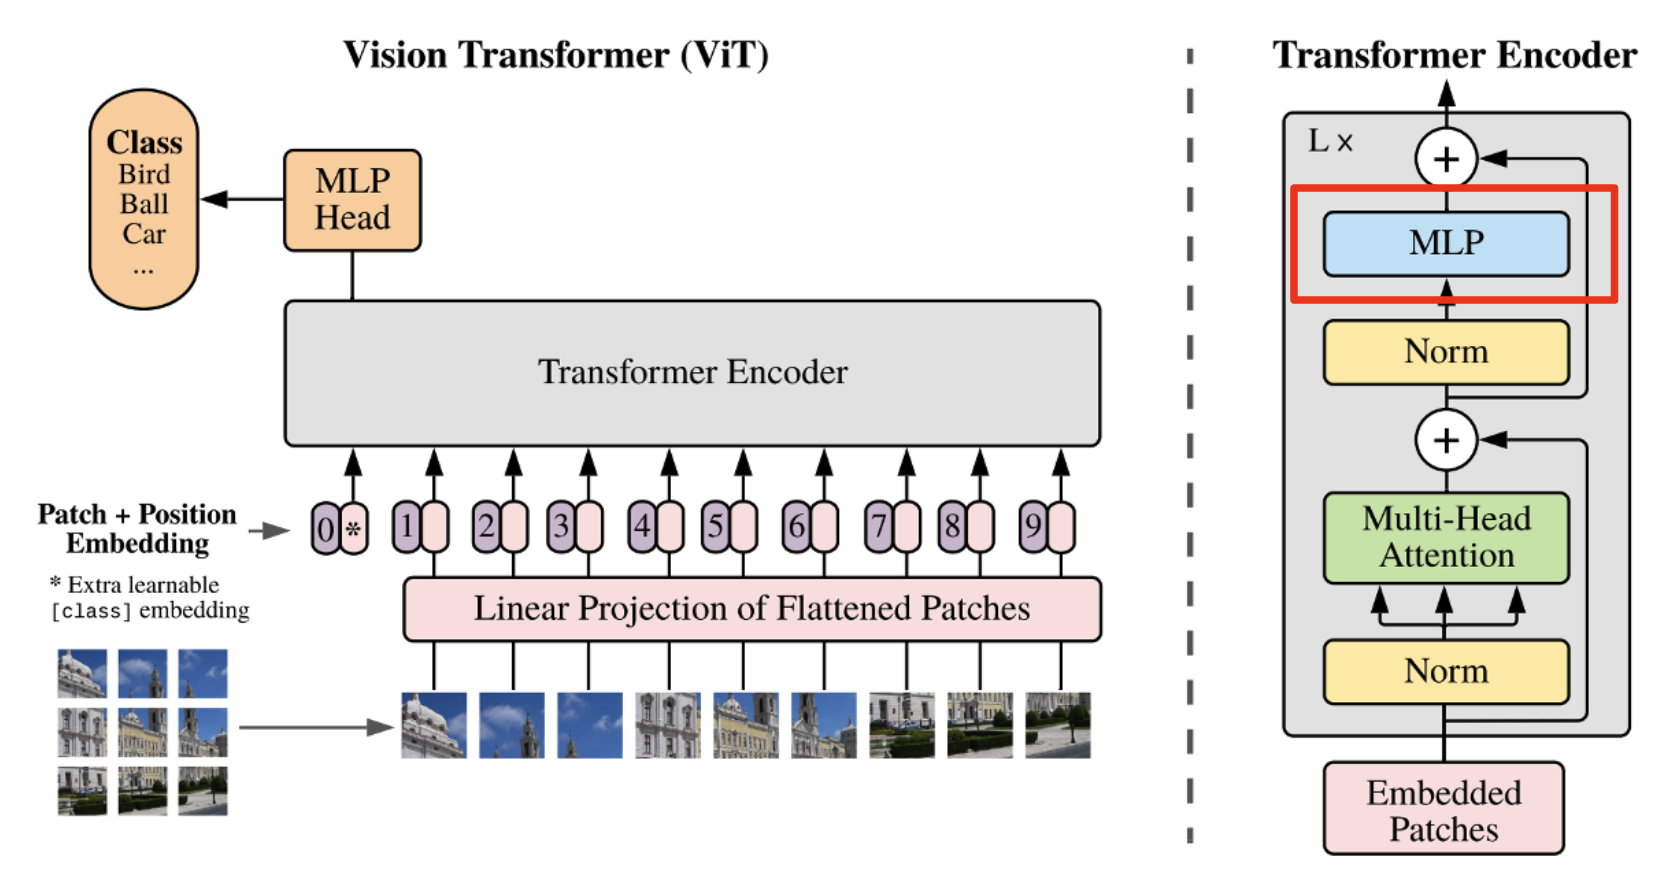

In [ ]:
class MLP(nn.Module):
    """Multilayer perceptron.
    #1 hidden layer

    Parameters
    ----------
    in_features : int
        Number of input features.

    hidden_features : int
        Number of nodes in the hidden layer.

    out_features : int
        Number of output features.

    p : float
        Dropout probability.

    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.

    act : nn.GELU #Gaussian Error Linear Unit
        GELU activation function.

    fc2 : nn.Linear
        The second linear layer.

    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # linear layer
        x = self.act(x)  # activation
        # x = self.drop(x)  # dropout (?)
        x = self.fc2(x)  # linear layer
        # x = self.drop(x)  # dropout

        return x

### Transformer Block
* x + Attention + MLP with LayerNorm

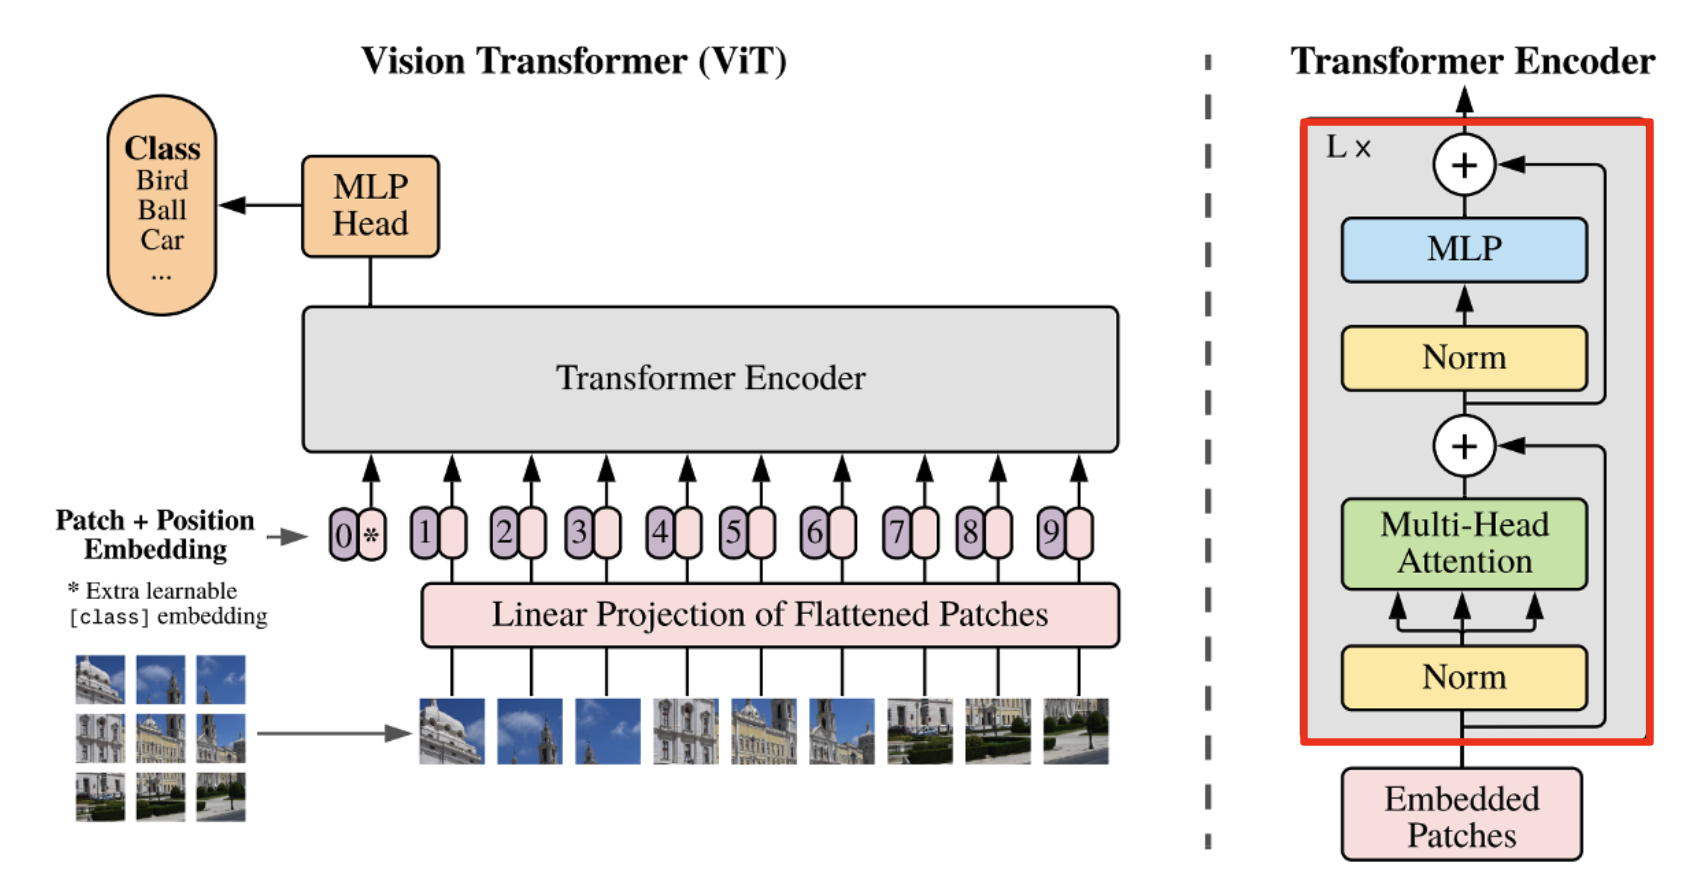

In [ ]:
class Block(nn.Module):
    """Transformer block.

    Parameters
    ----------
    dim : int
        Embeddinig dimension.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float #MLP의 hidden layer size
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.

    attn : Attention
        Attention module.

    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6) # normalization for attention
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        ) # attention layer
        self.norm2 = nn.LayerNorm(dim, eps=1e-6) # normalization for MLP
        hidden_features = int(dim * mlp_ratio) # hidden features = dim * mlp ratio(4)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x

### Vision Transformer

In [ ]:
class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.

    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).

    patch_size : int
        Both height and the width of the patch (it is a square).

    in_chans : int
        Number of input channels.

    n_classes : int
        Number of classes.

    embed_dim : int
        Dimensionality of the token/patch embeddings.

    depth : int
        Number of blocks.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.

    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.

    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.

    pos_drop : nn.Dropout
        Dropout layer.

    blocks : nn.ModuleList
        List of `Block` modules.

    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) # class token 0으로 초기화
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        ) # positional embedding 0으로 초기화 / class token이 추가되면서 patch의 수 1 증가
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                ) #모든 block의 hyperparameter는 같음
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes) # final embedding의 input


    def forward(self, x):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x) # input image -> patch embeddings

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        ) # class token을 sample dimension에 복제
        x = torch.cat((cls_token, x), dim=1) # patch embedding에 추가
        x = x + self.pos_embed # positional embedding 추가
        # x = self.pos_drop(x) # dropout

        for block in self.blocks: # block의 개수만큼 embedding 반복 수행
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # class token만 따로 추출
        x = self.head(cls_token_final)

        return x # 최종 출력: dataset class 수에 맞게 값이 나오고 최대값이 예측값이 됨

### Verify Implimentation

In [ ]:
!pip install timm #pretrianed model이 들어있음

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import timm
import torch

# Helpers
def get_n_params(module): # count the number of parameters
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def assert_tensors_equal(t1, t2): #tensor가 같은지 비교
    a1, a2 = t1.detach().numpy(), t2.detach().numpy()

    np.testing.assert_allclose(a1, a2)

model_name = "vit_base_patch16_384"
model_official = timm.create_model(model_name, pretrained=True) # pretrained model: vit_base_patch16_384
model_official.eval() #load one of the pre-trained vision transformer models
print(type(model_official))

custom_config = {
        "img_size": 384,
        "in_chans": 3,
        "patch_size": 16,
        "embed_dim": 768,
        "depth": 12,
        "n_heads": 12,
        "qkv_bias": True,
        "mlp_ratio": 4,
} # hyper parameters: pre-trained model에 해당하는

model_custom = VisionTransformer(**custom_config) # instantiate custom model
model_custom.eval() # set evaluation mode


for (n_o, p_o), (n_c, p_c) in zip(
        model_official.named_parameters(), model_custom.named_parameters()
):
    assert p_o.numel() == p_c.numel() # element 수가 같은지 비교
    # print(f"{n_o} | {n_c}")
    p_c.data[:] = p_o.data # redefine custom parameter -> official parameter

    assert_tensors_equal(p_c.data, p_o.data) # 잘 들어갔는지 double check

inp = torch.rand(1, 3, 384, 384)
res_c = model_custom(inp)
res_o = model_official(inp)

# Asserts
assert get_n_params(model_custom) == get_n_params(model_official) # trainable parameter 수가 같은지 확인
assert_tensors_equal(res_c, res_o) # output tensor가 같은지 확인

# Save custom model
# torch.save(model_custom, "/content/drive/MyDrive/수업/고급인공지능기술3/model.pth") #save model

<class 'timm.models.vision_transformer.VisionTransformer'>


### Model Output

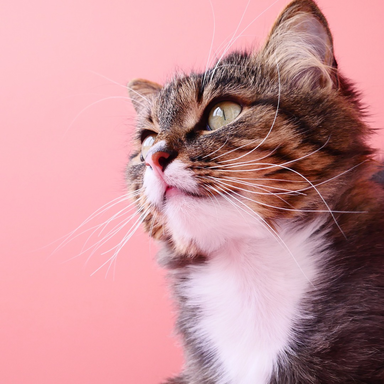

In [ ]:
import numpy as np
from PIL import Image
import torch
import cv2

k = 10 # 상위 10개의 항목만 나타냄

imagenet_labels = dict(enumerate(open("/content/drive/MyDrive/수업/고급인공지능기술3/classes.txt"))) # ImageNet classes text file

model = torch.load("/content/drive/MyDrive/수업/고급인공지능기술3/model.pth") # load pretrained model
model.eval()

img = (np.array(Image.open("/content/drive/MyDrive/수업/고급인공지능기술3/cat.png")) / 128) - 1  # in the range -1, 1 # load image
inp = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(torch.float32)
logits = model(inp)
probs = torch.nn.functional.softmax(logits, dim=-1) # logits -> probabilities

top_probs, top_ixs = probs[0].topk(k)

for i, (ix_, prob_) in enumerate(zip(top_ixs, top_probs)):
    ix = ix_.item()
    prob = prob_.item()
    cls = imagenet_labels[ix].strip()
    print(f"{i}: {cls:<45} --- {prob:.4f}")

0: tabby, tabby_cat                              --- 0.8001
1: tiger_cat                                     --- 0.1752
2: Egyptian_cat                                  --- 0.0172
3: lynx, catamount                               --- 0.0018
4: Persian_cat                                   --- 0.0011
5: Siamese_cat, Siamese                          --- 0.0002
6: bow_tie, bow-tie, bowtie                      --- 0.0002
7: weasel                                        --- 0.0001
8: lens_cap, lens_cover                          --- 0.0001
9: remote_control, remote                        --- 0.0001


In [ ]:
# 출처: https://youtu.be/ovB0ddFtzzA